In [1]:
from __future__ import print_function

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# Import and Clean Datasets
1. Hourly power output of Dominion Energy
2. Precipitation, Temperature, Snowfall, and Wind in Charlottesville

I chose these datasets sequentially: I found the Dominion Energy dataset online and got curious as to what I could do with it.

I then began thinking of features that I thought would be good predictors of regional power output, and arrived at the conclusion that weather data would be a very good predictor of power output. The main use of power anywhere tends to be heating and cooling: it is energy intensive to change the temperature of large amounts of air. From that, I decided to look into online weather datasets. I found a dataset recorded around the same time period, and close to the same frequency (hourly for power output, daily for temperature) for the Charlottesville area, and decided that it would be fun to use data from close to home to predict other data from close to home. 

As for data cleaning, I followed pretty standard protocols. Replace NaNs sensibly, figure out how best to represent data, which columns to use, etc.

In [5]:
hr_cons_df = pd.read_csv('DOM_hourly.csv')
hr_cons_df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [6]:
cville_weather_df = pd.read_csv('weather_cville.csv')
cville_weather_df.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,TMAX
0,US1VAAB0009,"SHADWELL 1.0 E, VA US",2013-09-01,NaN,0.0,0.0,NaN
1,US1VAAB0009,"SHADWELL 1.0 E, VA US",2013-09-02,NaN,0.0,0.0,NaN
2,US1VAAB0009,"SHADWELL 1.0 E, VA US",2013-09-03,NaN,0.0,0.0,NaN
3,US1VAAB0009,"SHADWELL 1.0 E, VA US",2013-09-04,NaN,0.0,0.0,NaN
4,US1VAAB0009,"SHADWELL 1.0 E, VA US",2013-09-05,NaN,0.0,0.0,NaN


## Clean hourly power output dataset 
1. Convert dataframe index to datetime and drop the "Datetime" column from hour
    1. Pandas has a massive amount of date indexing functions
    2. Makes it much easier to work with datetime data
2. Drop n/a values
3. Plot various rolling averages, summarize data, etc.

In [10]:
# Make the Datetime the index, allows for really easy visualization and manipulation
hr_cons_df.index = pd.to_datetime(hr_cons_df['Datetime'])
hr_cons_df = hr_cons_df.drop(['Datetime'],axis=1)

In [11]:
hr_cons_df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [12]:
# drop NAs (I don't think there any)
hr_cons_df = hr_cons_df.dropna()

In [13]:
# make sure data types make sense
hr_cons_df.dtypes

DOM_MW    float64
dtype: object

In [14]:
# describe data, get a sense of scale
hr_cons_df.describe()

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


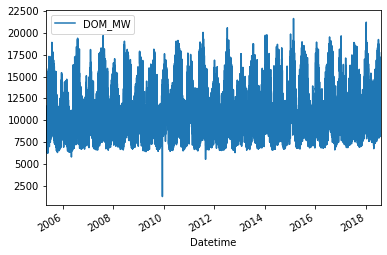

In [15]:
# hourly MW output
hr_cons_df.plot()

### Plot rolling averages to identify longer-term trends in data

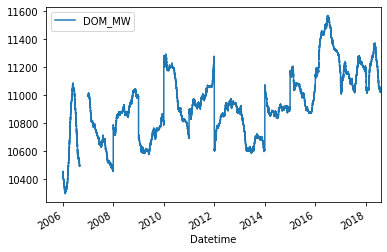

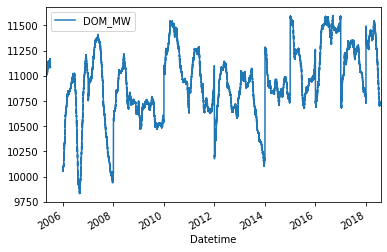

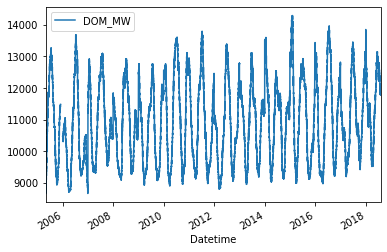

In [16]:
# one year rolling average of MW output
# 180 day rolling average of MW output
# 30 day rolling average of MW output
hr_cons_df.rolling(24*365).mean().plot()
hr_cons_df.rolling(24*180).mean().plot()
hr_cons_df.rolling(24*30).mean().plot()

### Make use of pandas "resample" function on dates
This function takes the median power output every day, effectively switching from hourly to daily sampling

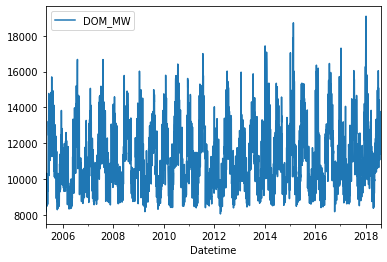

In [17]:
# 1 day resampling plot
hr_cons_df.resample("1d").median().plot()

### Plot autocorrelation of data with itself given different time delays
It's not very well correlated with itself, indicator of very noisy data

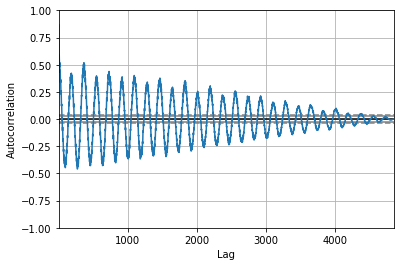

In [18]:
# autocorrelation plot of resampling
# seems to correlate well with itself every 200 or so days
# this seems to connect somewhat with peak of summer and peak of winter
pd.plotting.autocorrelation_plot(hr_cons_df.resample("1d").median())

## Clean Charlottesville Weather dataframe
1. Convert index to datetime, remove "DATE" column
2. Drop N/A values from TMAX column 
    1. TMAX is a very important indicator
    2. Temperature is variable enough that filling in with means or rolling means feels sketchy
    3. Definitely cannot fill in with 0s or -1s
3. Fill unrecorded SNOW data with 0s
    1. Snow doesn't seem to be a good indicator
    2. Unrecorded snow days can be safely assumed to mean no snow fell
4. Fill unrecorded average wind with the mean wind speed
    1. Wind doesn't seem to be a great indicator
    2. Wind is not super variable, so it's safe to call unrecorded days more or less average
5. Drop categorical STATION and NAME columns
    1. They are all similar, and mostly meaningless

In [19]:
cville_weather_df.index = pd.to_datetime(cville_weather_df['DATE'])
cville_weather_df = cville_weather_df.drop(['DATE'],axis=1)
cville_weather_df = cville_weather_df.dropna(subset=['TMAX'])
cville_weather_df['SNOW'] = cville_weather_df['SNOW'].fillna(0)
cville_weather_df['AWND'] = cville_weather_df['AWND'].fillna(cville_weather_df['AWND'].mean())
cville_weather_df = cville_weather_df.drop(['STATION','NAME'],axis=1)

In [37]:
cville_weather_df.head()

,AWND,PRCP,SNOW,TMAX
DATE,,,,
2007-03-30,4.533357,0.00,0.0,65.0
2007-03-31,4.533357,0.00,0.0,64.0
2007-04-01,4.533357,0.02,0.0,62.0
2007-04-02,4.533357,0.00,0.0,78.0
2007-04-03,4.533357,0.07,0.0,81.0


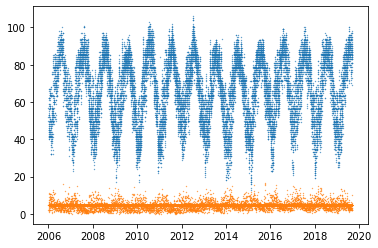

In [20]:
plt.scatter(cville_weather_df.index, cville_weather_df['TMAX'],s=0.1)
plt.scatter(cville_weather_df.index, cville_weather_df['AWND'],s=0.1)

### Test out some resampling (using medians and means for days)

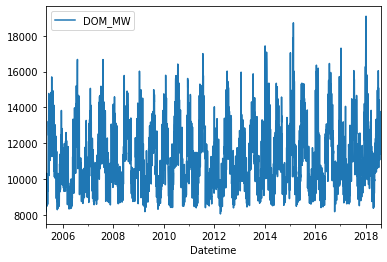

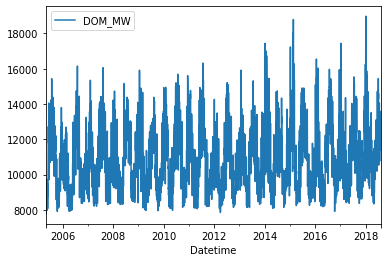

In [21]:
hr_cons_df.resample("1d").median().plot()
hr_cons_df.resample("1d").mean().plot()

#### Eventually settled on median for resampling

In [22]:
resampled_1d_cons = hr_cons_df.resample("1d").median()
resampled_1d_cons

,DOM_MW
Datetime,
2005-05-01,8205.0
2005-05-02,9169.5
2005-05-03,8921.0
2005-05-04,9067.5
2005-05-05,9069.5
...,...
2018-07-30,12168.5
2018-07-31,12643.0
2018-08-01,13771.0


### Merge weather and power output datasets by day
1. Drop average wind column (It's not at all related to power output)
2. Drop n/a values and get some statistics on the data

In [23]:
weather_power = cville_weather_df.merge(resampled_1d_cons, left_index=True, right_index=True)
weather_power = weather_power.drop('AWND',axis=1)

In [24]:
weather_power.head()

,PRCP,SNOW,TMAX,DOM_MW
2006-01-01,0.09,0.0,50.0,9646.0
2006-01-01,0.00,0.0,57.0,9646.0
2006-01-01,0.00,0.0,52.0,9646.0
2006-01-02,0.32,0.0,42.0,11158.0
2006-01-02,0.12,0.0,50.0,11158.0


In [25]:
weather_power.corr()

,PRCP,SNOW,TMAX,DOM_MW
PRCP,1.000000,0.122667,-0.018062,-0.031585
SNOW,0.122667,1.000000,-0.120979,0.084239
TMAX,-0.018062,-0.120979,1.000000,0.052148
DOM_MW,-0.031585,0.084239,0.052148,1.000000


In [26]:
weather_power.describe()

,PRCP,SNOW,TMAX,DOM_MW
count,20520.000000,20629.000000,20629.000000,20629.000000
mean,0.123592,0.028470,66.385574,11203.508410
std,0.355761,0.433301,17.420460,1731.138182
min,0.000000,0.000000,13.000000,8050.500000
25%,0.000000,0.000000,53.000000,9787.500000
50%,0.000000,0.000000,68.000000,10887.000000
75%,0.040000,0.000000,81.000000,12394.500000
max,7.120000,16.500000,106.000000,19093.500000


1. Normalize all of the values to the range [0,1)
2. Drop all of the N/A values again (they keep popping up)

In [36]:
norm_wp

,PRCP,SNOW,TMAX,DOM_MW
2006-01-01,0.012640,0.0,0.397849,0.144481
2006-01-01,0.000000,0.0,0.473118,0.144481
2006-01-01,0.000000,0.0,0.419355,0.144481
2006-01-02,0.044944,0.0,0.311828,0.281400
2006-01-02,0.016854,0.0,0.397849,0.281400
...,...,...,...,...
2018-08-02,0.089888,0.0,0.774194,0.472833
2018-08-03,0.026685,0.0,0.655914,0.301956
2018-08-03,0.125000,0.0,0.720430,0.301956
2018-08-03,0.110955,0.0,0.752688,0.301956


In [38]:
norm_wp = (weather_power-weather_power.min())/(weather_power.max()-weather_power.min())

In [39]:
norm_wp = norm_wp.dropna()
norm_wp

,PRCP,SNOW,TMAX,DOM_MW
2006-01-01,0.012640,0.0,0.397849,0.144481
2006-01-01,0.000000,0.0,0.473118,0.144481
2006-01-01,0.000000,0.0,0.419355,0.144481
2006-01-02,0.044944,0.0,0.311828,0.281400
2006-01-02,0.016854,0.0,0.397849,0.281400
...,...,...,...,...
2018-08-02,0.089888,0.0,0.774194,0.472833
2018-08-03,0.026685,0.0,0.655914,0.301956
2018-08-03,0.125000,0.0,0.720430,0.301956
2018-08-03,0.110955,0.0,0.752688,0.301956


### Get all of the columns to individual variables

In [40]:
prcp = norm_wp['PRCP']
snow = norm_wp['SNOW']
tmax = norm_wp['TMAX']
output = norm_wp['DOM_MW']

In [41]:
full_input = [prcp,snow,tmax]

### Plot each variable against the power output
1. PRCP isn't bad
2. Snow doesn't appear well correlated in general, but spike sort of line up
3. TMAX is spot on, could probably make a model with nothing but TMAX
  1. Positive and negative spikes are almost perfectly correlated to output

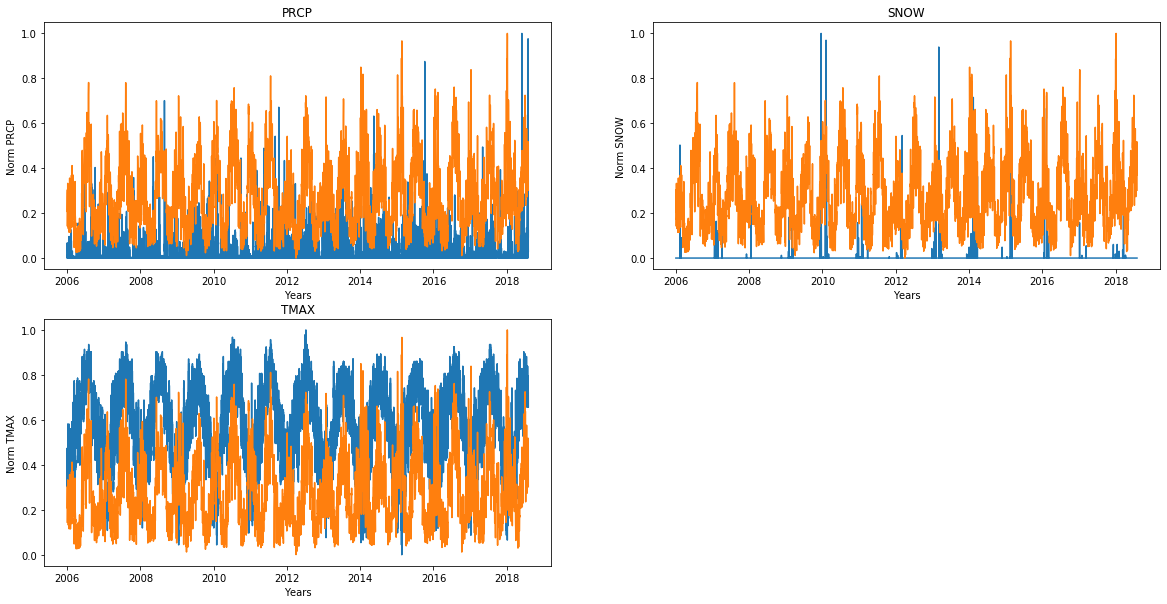

In [42]:
fig = plt.figure(figsize=(20,10))
titles = norm_wp.columns[:-1]
for i, array in enumerate(full_input):
    ax = fig.add_subplot(2,2,i+1)
    ax.set_title(titles[i])
    ax.set_xlabel('Years')
    ax.set_ylabel('Norm '+titles[i])
    ax.plot(array)
    ax.plot(output)
plt.show()

### Intuitively guess at a good model for predicting power output
Does a really good job :)

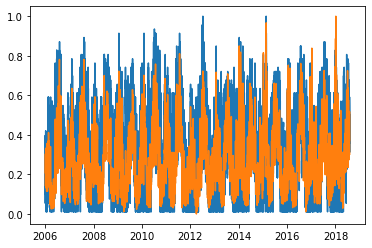

In [43]:
plt.plot(abs(tmax*2-1))
plt.plot(output)
plt.show()

### Give some fun z-score norms a chance
(They aren't very good)

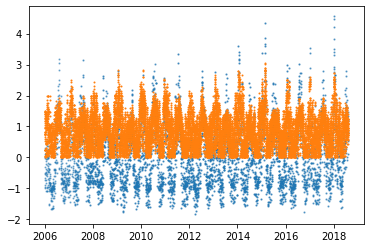

In [44]:
plt.scatter(weather_power.index,(weather_power['DOM_MW']-np.mean(weather_power['DOM_MW']))/np.std(weather_power['DOM_MW']), alpha=0.2, s=1)
plt.scatter(weather_power.index,abs((weather_power['TMAX']-np.mean(weather_power['TMAX']))/np.std(weather_power['TMAX'])), s=1)

### Reformat data to be passed into a neural network
1. Create a training and test set
2. No validation set, not enough data to justify

In [56]:
inputs = np.array(list(zip(prcp,snow,tmax)))[:15000]
inputs_test = np.array(list(zip(prcp,snow,tmax)))[15000:]
inputs = inputs.reshape((1,)+inputs.shape)
inputs_test = inputs_test.reshape((1,) + inputs_test.shape)

In [57]:
outputs = np.array(list(output))[:15000]
outputs_test = np.array(list(output))[15000:]
outputs = outputs.reshape((1,)+outputs.shape)
outputs_test = outputs_test.reshape((1,) + outputs_test.shape)

### Create a neural network
1. Two 100-width Gated Recurrent Units (variant on LSTM without long term memory)
2. Dense layer for single-variable output
3. Many-to-one network, generate sequence one output at a time
4. Use RMSProp optimizer and mean squared error

In [58]:
network = tf.keras.Sequential()
network.add(tf.keras.layers.GRU(100,return_sequences=True, input_shape=(None,3)))
network.add(tf.keras.layers.GRU(100,return_sequences=True))
network.add(tf.keras.layers.Dense(1,activation='linear'))
network.compile(optimizer=tf.keras.optimizers.RMSprop(),
               loss='mse',
               metrics=['mse'])

### Fit the model
1. 2 epochs (decided experimentally, fights overfitting by cutting off training pretty early. The model ends up very low in loss very quickly.
2. SGD Batch Size of 128

In [59]:
network.fit(inputs,
            outputs,
            epochs=2,
            batch_size=128)

Epoch 1/2
1/1 [==============================] - 58s 58s/sample - loss: 0.0755 - mean_squared_error: 0.0755
Epoch 2/2
1/1 [==============================] - 49s 49s/sample - loss: 0.0546 - mean_squared_error: 0.0546


#### Output isn't super good
1. Seems to more or less match up with TMAX  instead of getting output correct
2. Likely due to lack of large amounts of data

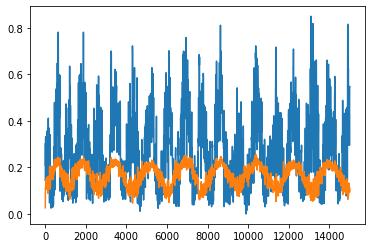

In [60]:
# Test the model's predictions on the data it was trained on (bad practice, I'm just curious)
plt.plot(outputs.flatten())
plt.plot(network.predict(inputs).flatten())

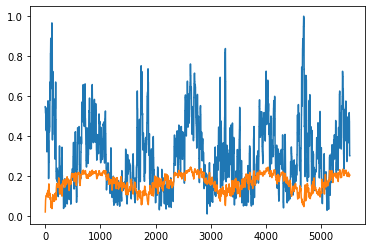

In [61]:
# Test the model's predictions on test data
plt.plot(outputs_test.flatten())
plt.plot(network.predict(inputs_test).flatten())

# Problems with current implementation:
1. Not a lot of data available
    1. Only about 6000 data points (one per day since ~~2005)
    2. Only really using temperature, precipipation, and snowfall
2. Neural network architecture not well suited to extremely spiky data
    1. RNNs are much better suited for predicting gently sloping, long-term trends in data
    2. Much worse at predicting large spikes in data
    3. Evidence: the NN output predicts the spikes when they occur, but doesn't get their magnitude correct
3. Predicting one data point at a time is not the best way to do things
    1. Could find much better results (I think) by predicting sequences instead of single values

# Where to take this next:
1. Get much, much more data
    1. Look at data from more regions
    2. Try to find hourly weather updates
2. Examine different features than temperature, etc.
    1. Try to find CO<sub>2</sub> emissions to use as inputs
    2. Switch around: use power output to predict other things
        1. Use trends in power output to predict population size of a region
        2. Use trends in power output to predict CO<sub>2</sub> emissions
3. Use a neural network architecture better suited for spiky/noisy data
    1. [Noisy TimeSeries Prediction using a Recurrent Neural Network and Grammatical Inference (Paper by PSU)](https://clgiles.ist.psu.edu/papers/MLJ-finance.pdf)
    2. [Training Recurrent Neural Networks against Noisy Computations during Inference](https://arxiv.org/pdf/1807.06555.pdf)
4. Apply smoothing to the data
    1. Use a longer-term sampling rate
    2. Apply some algorithmic smoothing function to the data
        1. Very risky technique in terms of model robustness